# Active Inference Ship navigation

This notebooks covers fundamentals of the Active Inference framework implemented with the Bethe Free Energy optimisation with message passing on factor graphs. We refer reader to the [Thijs van de Laar (2019) "Simulating active inference processes by message passing"](https://doi.org/10.3389/frobt.2019.00020) original paper with more in-depth overview and explanation of the active inference agent implementation by message passing.

In [296]:
import Pkg; Pkg.activate("."); Pkg.instantiate();

  Activating project at `~/Documents/GitHub/Focus-group-control/Ship`


In [297]:
using RxInfer
using Plots
default(label="", margin=10Plots.pt)

## System dynamics

In [298]:
#We need control rudder and accelerator for turning and accelerate. But at first, we only consider turning rate
function ship_dynamic(engine_force_limit=0.1)
    B =[ 0.0,0.0,1.0,0.0 ]
    turning_rate=(a::Real) -> begin
        B*engine_force_limit*tanh(a)
    end
    return (turning_rate)
end

ship_dynamic (generic function with 2 methods)

In [299]:
turning_rate=ship_dynamic(
)

#583 (generic function with 1 method)

In [300]:
initial_position = [-0.0,0.0,(3/2)π,3.0]

4-element Vector{Float64}:
 -0.0
  0.0
  4.71238898038469
  3.0

In [301]:
function getAFromState(x,δt)
    A=zeros(4)
    A[1]=x[4]*cos(x[3])*δt
    A[2]=x[4]*sin(x[3])*δt
    return A
end

getAFromState (generic function with 1 method)

In [302]:
getAFromState(initial_position,1)

4-element Vector{Float64}:
 -5.51091059616309e-16
 -3.0
  0.0
  0.0

# World - agent interaction

Because the states of the world are unknown to the agent, we wrap them in a comprehension. The comprehension returns only the functions for interacting with the world and not the hidden states. This way, we introduce a stateful world whose states cannot be directly observed.

In [303]:
function create_world(;turning_rate, initial_position = [0.5,0.5,0.1,3.0])

    y_t_min = initial_position
    # y_dot_t_min = initial_velocity
    
    y_t = y_t_min
    # y_dot_t = y_dot_t_min
    
    execute = (rudder::Float64) -> begin
        
        # Compute next state
        y_t = getAFromState(y_t_min,1) + y_t_min + turning_rate(rudder)
    
        # Reset state for next step
        y_t_min = y_t
    end
    
    observe = () -> begin 
        return y_t
    end
        
    return (execute, observe)
end

create_world (generic function with 1 method)

## Naive approach

In this simulation we are going to perform a naive action policy for tight full-power only. In this case, with limited engine power, the agent should not be able to achieve its goal:

Plots.AnimatedGif("/Users/jia/Documents/GitHub/Focus-group-control/Ship/figures/shipnav-naive.gif")
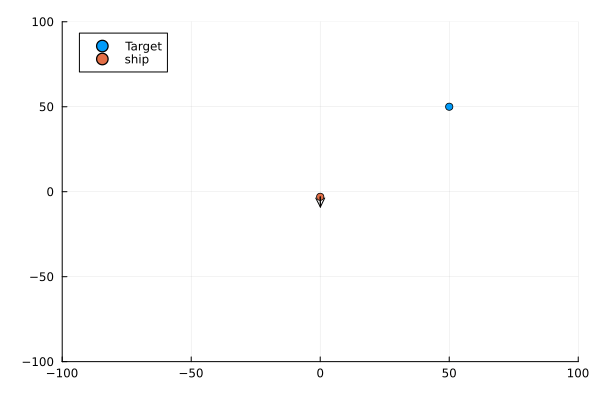

In [304]:
N_naive  = 100 # Total simulation time
pi_naive = 0.1 # Naive policy for right full-power only

# Let there be a world
(execute_naive, observe_naive) = create_world(; 
turning_rate = turning_rate,
    initial_position = initial_position, 
);

y_naive = Vector{Vector{Float64}}(undef, N_naive)
for t = 1:N_naive
    execute_naive(pi_naive) # Execute environmental process
    y_naive[t] = observe_naive() # Observe external states
end

x_target=[100.0,100.0,0.0*π,3.0]

animation_naive = @animate for i in 1:N_naive
    # plot(valley_x, valley_y, title = "Naive policy", label = "Landscape", color = "black", size = (800, 400))
    # scatter([y_naive[1][1]], [y_naive[1][2]])
    # plot(y_naive[1][1],y_naive[1:i][2])
    scatter([50], [50],xlims = (-100,100),ylims = (-100,100), label = "Target")
    scatter!([y_naive[i][1]], [y_naive[i][2]],xlims = (-100,100),ylims = (-100,100),label = "ship")
    plot!([y_naive[i][1],y_naive[i][1]+2*y_naive[i][4]*cos(y_naive[i][3])],[y_naive[i][2],y_naive[i][2]+2*y_naive[i][4]*sin(y_naive[i][3])],arrow=true,color=:black,label="")
    
    # scatter!([x_target[1]], [height(x_target[1])], label="goal")   
end

gif(animation_naive, "figures/shipnav-naive.gif", fps = 24, show_msg = false)

[](ai-mountain-car-naive.gif)

# Active inference approach

In the active inference approach we are going to create an agent that models the environment around itself as well as the best possible actions in a probabilistic manner.

The code in the next block defines the agent's internal beliefs over the external dynamics and its probabilistic model of the environment, which correspond accurately by directly using the functions defined above. We use the `@model` macro from `RxInfer` to define the probabilistic model and the `meta` block to define approximation methods for the nonlinear state-transition functions.

In the model specification we in addition to the current state of the agent we include the beliefs over its future states (up to `T` steps ahead):

In [305]:
hhh = (u::AbstractVector) -> turning_rate(u[1])

#590 (generic function with 1 method)

In [306]:
turning_rate

#583 (generic function with 1 method)

In [307]:
hh = (u::AbstractVector) -> turning_rate(u[1])

#592 (generic function with 1 method)

In [308]:
@model function shipnav(; T,turning_rate)
    
    # Transition function modeling transition due to gravity and friction
    g = (s_t_min::AbstractVector) -> begin 
        s_t = similar(s_t_min) # Next state
        s_t=getAFromState(s_t_min,1.0) + s_t_min
        return s_t
    end
    
    # Function for modeling engine control
    h = (u::AbstractVector) -> turning_rate(u[1])
    
    # Inverse engine force, from change in state to corresponding engine force
    # h_inv = (delta_s_dot::AbstractVector) -> [atanh(clamp(delta_s_dot[2], -engine_force_limit+1e-3, engine_force_limit-1e-3)/engine_force_limit)] 
    
    # C = constvar([1. 0. 0. 0.;
    #               0. 1. 0. 0.])

    # Internal model perameters
    Gamma = 1e4*diageye(4) # Transition precision
    Theta = 1e-4*diageye(4) # Observation variance
    
    m_s_t_min = datavar(Vector{Float64})
    V_s_t_min = datavar(Matrix{Float64})

    s_t_min ~ MvNormal(mean = m_s_t_min, cov = V_s_t_min)
    s_k_min = s_t_min
    
    m_u = datavar(Vector{Float64}, T)
    V_u = datavar(Matrix{Float64}, T)
    
    m_x = datavar(Vector{Float64}, T)
    V_x = datavar(Matrix{Float64}, T)
    
    u = randomvar(T)
    s = randomvar(T)
    x = randomvar(T)
    
    u_h_k = randomvar(T)
    s_g_k = randomvar(T)
    u_s_sum = randomvar(T)

    for k in 1:T
        u[k] ~ MvNormal(mean = m_u[k], cov = V_u[k])
        # bb=truncated(Normal(0,1), 0, Inf)
        # u[k] ~ truncated(MvNormal(mean = m_u[k], cov = V_u[k]),0, Inf)
        u_h_k[k] ~ h(u[k]) where { meta = DeltaMeta(method = Unscented()) }
        s_g_k[k] ~ g(s_k_min) where { meta = DeltaMeta(method = Unscented()) }
        u_s_sum[k] ~ s_g_k[k] + u_h_k[k]
        s[k] ~ MvNormal(mean = u_s_sum[k], precision = Gamma)
        x[k] ~ MvNormal(mean = s[k], cov = Theta)
        x[k] ~ MvNormal(mean = m_x[k], cov = V_x[k]) # goal
        s_k_min = s[k]
    end
    
    return (s, )
end

In [309]:
# We are going to use some private functionality from ReactiveMP, 
# in the future we should expose a proper API for this
import RxInfer.ReactiveMP: getrecent, messageout

function create_agent(; T = 20, turning_rate, x_target, initial_position)
    Epsilon = fill(0.9, 1, 1)                 # Control prior variance
    m_u = Vector{Float64}[ [ 0.0] for k=1:T ] # Set control priors
    V_u = Matrix{Float64}[ Epsilon for k=1:T ]

    Sigma    = 1e-8*diageye(4) # Goal prior variance
    Sigma[3,3]=1e8
    Sigma[4,4]=1e8
    m_x      = [zeros(4) for k=1:T]
    m_x[end]      = x_target
    V_x      = [huge*diageye(4) for k=1:T]
    V_x[end] = Sigma # Set prior to reach goal at t=T

    # Set initial brain state prior
    m_s_t_min = initial_position
    V_s_t_min = tiny * diageye(4)
    
    # Set current inference results
    result = nothing
    pol = zeros(T)

    # The `infer` function is the heart of the agent
    # It calls the `RxInfer.inference` function to perform Bayesian inference by message passing
    infer = (upsilon_t::Float64, y_hat_t::Vector{Float64}) -> begin
        m_u[1] = [ upsilon_t ] # Register action with the generative model
        V_u[1] = fill(tiny, 1, 1) # Clamp control prior to performed action

        m_x[1] = y_hat_t # Register observation with the generative model
        V_x[1] = tiny*diageye(4) # Clamp goal prior to observation

        data = Dict(:m_u       => m_u, 
                    :V_u       => V_u, 
                    :m_x       => m_x, 
                    :V_x       => V_x,
                    :m_s_t_min => m_s_t_min,
                    :V_s_t_min => V_s_t_min)
        
        model  = shipnav(; T = T, turning_rate) 
        result = inference(model = model, data = data)
        # pol = [mode(result.posteriors[:u][k])[1] for k=1:T]
    end
    
    # The `act` function returns the inferred best possible action
    # act() = pol[1]
    
    act = () -> begin
        if result !== nothing
            return mode(result.posteriors[:u][3])[1] ##
        else
            return 0.0 # Without inference result we return some 'random' action
        end
    end
    
    # The `future` function returns the inferred future states
    future = () -> begin 
        if result !== nothing 
            return getindex.(mode.(result.posteriors[:s]), 1)
        else
            return zeros(T)
        end
    end

    # The `slide` function modifies the `(m_s_t_min, V_s_t_min)` for the next step
    # and shifts (or slides) the array of future goals `(m_x, V_x)` and inferred actions `(m_u, V_u)`
    slide = () -> begin
        (s, ) = result.returnval
        
        slide_msg_idx = 3 # This index is model dependend
        (m_s_t_min, V_s_t_min) = mean_cov(getrecent(messageout(s[2], slide_msg_idx)))

        m_u = circshift(m_u, -1)
        m_u[end] = [0.0]
        # m_u = pol
        V_u = circshift(V_u, -1)
        V_u[end] = Epsilon

        m_x = circshift(m_x, -1)
        m_x[end] = x_target
        V_x = circshift(V_x, -1)
        V_x[end] = Sigma
    end

    return (infer, act, slide, future)    
end

create_agent (generic function with 1 method)

Plots.AnimatedGif("/Users/jia/Documents/GitHub/Focus-group-control/Ship/shipnav-aif.gif")
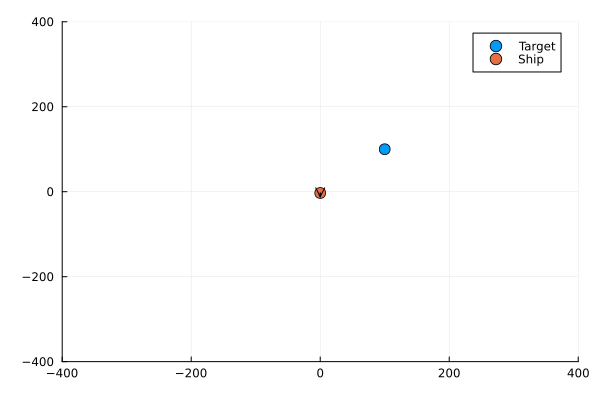

In [310]:
(execute_ai, observe_ai) = create_world(;
    turning_rate, 
    initial_position = initial_position
    # initial_velocity = initial_velocity
) # Let there be a world

T_ai = 50

(infer_ai, act_ai, slide_ai, future_ai) = create_agent(; # Let there be an agent
    T  = T_ai, 
    turning_rate=turning_rate,
    x_target = x_target,
    initial_position = initial_position
    # initial_velocity = initial_velocity
) 

N_ai = 100

# Step through experimental protocol
agent_a = Vector{Float64}(undef, N_ai) # Actions
agent_f = Vector{Vector{Float64}}(undef, N_ai) # Predicted future
agent_x = Vector{Vector{Float64}}(undef, N_ai) # Observations
pp=[]
for t=1:N_ai
    agent_a[t] = act_ai()            # Invoke an action from the agent
    agent_f[t] = future_ai()         # Fetch the predicted future states
    execute_ai(agent_a[t])           # The action influences hidden external states
    agent_x[t] = observe_ai()        # Observe the current environmental outcome (update p)
    res=infer_ai(agent_a[t], agent_x[t]) # Infer beliefs from current model state (update q)
    push!(pp,res)
    slide_ai()                       # Prepare for next iteration
end

animation_ai = @animate for i in 1:N_ai
    scatter([x_target[1]], [x_target[2]],xlims = (-400,400),ylims = (-400,400),label = "Target",markersize=6)
    scatter!([agent_x[i][1]], [agent_x[i][2]],xlims = (-400,400),ylims = (-400,400),label = "Ship",markersize=6)
    plot!([agent_x[i][1],agent_x[i][1]+3*agent_x[i][4]*cos(agent_x[i][3])],[agent_x[i][2],agent_x[i][2]+3*agent_x[i][4]*sin(agent_x[i][3])],arrow=true,color=:black,label="")
    
    # scatter!([x_target[1]], [height(x_target[1])], label="goal")   
end

    
gif(animation_ai, "./shipnav-aif.gif", fps = 24, show_msg = false)

In [312]:
using JLD
r = rand(3, 3, 3)
save("data/data.jld", "data", agent_x)
# load("data.jld")["data"]